# Evaluate Mispredictions

This notebook evaluates parses the results of the simulation and plots the number of mispredictions for each configuration. It also serves to reproduce the main results (Figure 9) in the paper.


In [1]:

import pandas as pd
import numpy as np
import re


import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
from matplotlib.patches import Patch, PathPatch
from matplotlib.ticker import LinearLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.ticker as mticker

## Loading and parsing the data

In [10]:

dict = {}



models = [

    ("tage64kscl", "64K TSL"),
    ("tage512kscl", "512K TSL"),
    ("llbp-timing", "LLBP"),
    ("llbp", "LLBP-0Lat"),

]



bms = [
    ('nodeapp-nodeapp', 'NodeApp'),
    ('mwnginxfpm-wiki', 'PHPWiki'),

    ('benchbase-tpcc', 'TPCC'),
    ('benchbase-twitter', 'Twitter'),
    ('benchbase-wikipedia', 'Wikipedia'),
    ('dacapo-kafka', 'Kafka'),
    ('dacapo-spring', 'Spring'),
    ('dacapo-tomcat', 'Tomcat'),
    ('renaissance-finagle-chirper', 'Chirper'),
    ('renaissance-finagle-http', 'HTTP'),

    ('charlie.1006518', 'Charlie'),
    ('delta.507252', 'Delta'),
    ('merced.467915', 'Merced'),
    ('whiskey.426708', 'Whiskey'),
]




dfall = pd.DataFrame()

# data = {}

for cfg, n in models:

    dftmp = pd.DataFrame()
    for bm,name in bms:

        with open(f"../results/{bm}/{cfg}-ae-New.txt") as f:

            dict = { "Model" : n, "Benchmark" : name}


            for line in f:
                if "ROI INSTRUCTIONS" in line:
                    dict["Ninst"] = int(line.split()[-1])
                if "ROI MISPREDICTIONS" in line:
                    dict["Misp"] = int(line.split()[-1])
                if "ROI MPKI" in line:
                    dict["MPKI"] = float(line.split()[-1])


            dftmp = pd.concat([dftmp, pd.DataFrame(dict, index=[0])])

    print(n, len(dftmp))

    dm = {"Model": n, "Benchmark": "Mean" }
    for metric in dftmp.columns[2:]:
        dm[metric] = dftmp[metric].mean()

    dfall = pd.concat([dfall, dftmp, pd.DataFrame([dm])])



## Calculate MPKI reduction
dfall["MPKI Reduction"] = 0.0
ref = "64K TSL"

for bm in dfall["Benchmark"].unique():

    m = "misp"
    m = "MPKI"

    tage64ksc_mpki = dfall.loc[(dfall["Benchmark"] == bm) & (dfall["Model"] == ref), m].values[0]
    dfall.loc[dfall["Benchmark"] == bm, "MPKI Reduction"] = (tage64ksc_mpki - dfall.loc[dfall["Benchmark"] == bm, m]) / tage64ksc_mpki


64K TSL 14
512K TSL 14
LLBP 14
LLBP-0Lat 14


## Absolute MPKI

('tage64kscl', '64K TSL')
('llbp', 'LLBP')
('tage512kscl', '512K TSL')


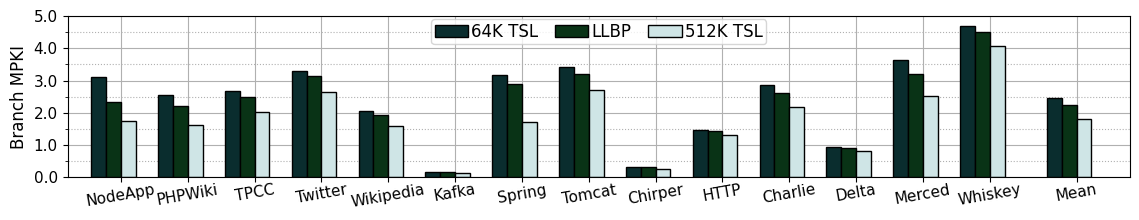

In [12]:


width = 0.7       # the width of the bars: can also be len(x) sequence


cw=11.5
fs=12

fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

_bms = [b[1] for b in bms] + ["Mean"]

x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

colors = {
    '64K TSL' : '#0a2d2e',
    "512K TSL" : '#cfe5e6',
    "LLBP" : '#093316',
    "LLBP-0Lat" : '#3e6f70',
}


nbars = len(models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


models = [

    ("tage64kscl", "64K TSL"),
    # ("tage512kscl-new", "512K TSL"),
    ("llbp", "LLBP"),
    # ("llbp-0lat", "LLBP-0Lat"),
    ("tage512kscl", "512K TSL"),
]



ax = axs

m = "MPKI"

for i, model in enumerate(models):

    # if i == 0:
    #     continue


    print(model)
    dftmp = dfall[dfall["Model"] == model[1]].set_index("Benchmark")

    y = dftmp.loc[_bms, m].values



    ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model[1]], label=model[1],
            align='edge', edgecolor='k',zorder=2.3)





## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel("Branch MPKI", fontsize=fs)

_y = ax.get_yticks()
ax.set_yticks(_y)
ax.set_yticklabels([f"{y:.1f}" for y in _y], fontsize=fs-1)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=7, fmt="%.2f", rotation=90)


## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

ax.set_ylim(bottom=-0.0, top=5)



handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, bbox_to_anchor=(0.5,1.03), loc="upper center", fontsize=fs, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

# ax.legend(loc="best", fontsize="9", )
ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)





fig.tight_layout()


fig.savefig("mpki.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")
# fig.savefig("performance_study.png",dpi=300,bbox_inches='tight', pad_inches=0, facecolor="w")

## MPKI Reduction

('llbp', 'LLBP')
('llbp-0lat', 'LLBP-0Lat')
('tage512kscl', '512K TSL')


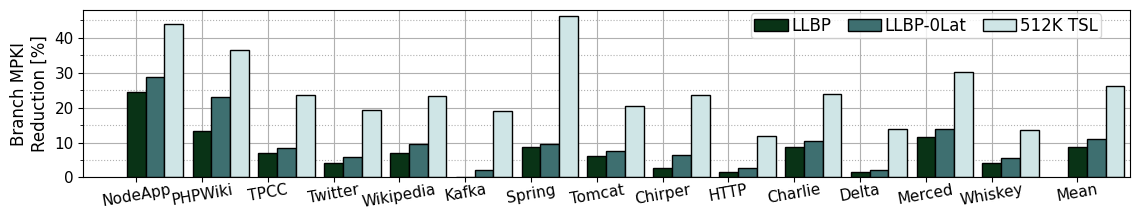

In [13]:


width = 0.7
cw=11.5
fs=12

fig, axs = plt.subplots(1, 1, figsize=(cw,cw*0.2), sharex=True, sharey=False)

_bms = [b[1] for b in bms] + ["Mean"]

x = np.array([x_+0.3 if l in ["GMean", "Mean"] else x_ for x_,l in enumerate(_bms)])

colors = {
    '64K TSL' : '#0a2d2e',
    "512K TSL" : '#cfe5e6',
    "LLBP" : '#093316',
    "LLBP-0Lat" : '#3e6f70',
}


nbars = len(models)
bar_width = float(1) / float(nbars+0.5)
init_offset = float(-nbars*bar_width) / 2
get_offset = lambda n : init_offset + n * bar_width


models = [

    ("tage64kscl", "64K TSL"),
    ("llbp", "LLBP"),
    ("llbp-0lat", "LLBP-0Lat"),
    ("tage512kscl", "512K TSL"),
]



ax = axs

m = "MPKI Reduction"

for i, model in enumerate(models):

    if i == 0:
        continue


    print(model)
    dftmp = dfall[dfall["Model"] == model[1]].set_index("Benchmark")

    y = dftmp.loc[_bms, m].values



    ax.bar(x+get_offset(i), y, width=bar_width, bottom=0, #hatch=hatches[j],
            color=colors[model[1]], label=model[1],
            align='edge', edgecolor='k',zorder=2.3)





## Grid
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.grid(True, which='both')
ax.grid(True, which='minor', linestyle=':')

ax.set_ylabel("Branch MPKI\nReduction [%]", fontsize=fs)

_y = ax.get_yticks()
ax.set_yticks(_y)
ax.set_yticklabels([f"{y*100:.0f}" for y in _y], fontsize=fs-1)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=7, fmt="%.3f", rotation=90)


## Format x-axis
ax.set_xticks(x)
ax.set_xticklabels(_bms, rotation=10, horizontalalignment="center", fontsize=fs-1)
ax.tick_params(axis='x', which='major', pad=0)

ax.set_ylim(bottom=-0.0, top=0.48)



handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, bbox_to_anchor=(0.98,1.03), loc="upper right", fontsize=fs, ncol=8,
            labelspacing=0.05, columnspacing=1.,handletextpad=0.2,borderpad=0.2,frameon=True)

ax.set_xlim(left=x[0]-0.8, right=x[-1]+0.8)





fig.tight_layout()


fig.savefig("mpki_reduction.pdf",dpi=300,format="pdf",bbox_inches='tight', pad_inches=0, facecolor="w")